In [1]:
import os.path as op

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import AFQ.registration as reg

In [4]:
from glob import glob
import nibabel as nib

In [5]:
path = '/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/'

In [6]:
real_a_files = glob(op.join(path, 'IXI029*real_A*'))
real_b_files = glob(op.join(path, 'IXI029*real_B*'))
fake_b_files = glob(op.join(path, 'IXI029*fake_B*'))

In [7]:
real_a_files.sort()
real_b_files.sort()
fake_b_files.sort()

In [8]:
real_a = np.zeros((len(real_a_files), 128, 128, 3))
real_b = np.zeros((len(real_a_files), 128, 128, 3))
fake_b = np.zeros((len(real_a_files), 128, 128, 3))
for ii in range(len(real_a_files)):
    real_a[ii]= np.load(real_a_files[ii]) 
    real_b[ii]= np.load(real_b_files[ii]) 
    fake_b[ii]= np.load(fake_b_files[ii])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


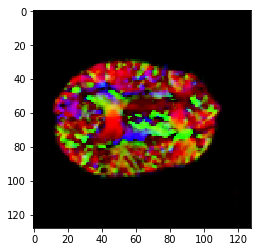

In [9]:
plt.imshow(fake_b[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


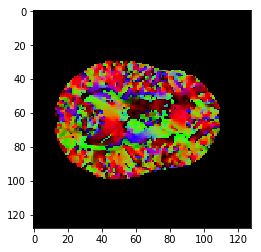

In [10]:
plt.imshow(real_b[27])

In [11]:
meanV1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmedian_V1.nii.gz')

In [12]:
meanV1 = meanV1_img.get_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


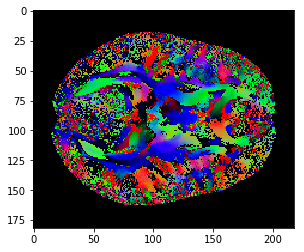

In [13]:
plt.imshow(meanV1[:, :, 80])

In [14]:
meant1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_t1.nii.gz')

In [15]:
meant1 = meant1_img.get_data()

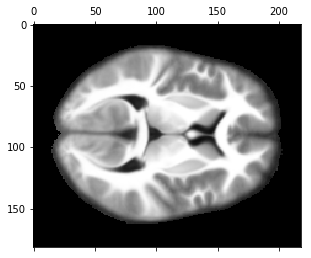

In [16]:
plt.matshow(meant1[:, :, 80], cmap='gray')

In [17]:
meanV1.shape

(182, 218, 182, 3)

In [18]:
meant1.shape

(182, 218, 182)

In [19]:
ants_brain_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-T1_ants_brainextractionBrainExtractionBrain.nii.gz')

In [20]:
ants_brain = ants_brain_img.get_data()

In [22]:
transformed, affine = reg.affine_registration(meant1, ants_brain, meant1_img.affine, ants_brain_img.affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [23]:
warped_meant1, mapping = reg.syn_registration(meant1, ants_brain, moving_affine=meant1_img.affine, static_affine=ants_brain_img.affine, prealign=affine)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [25]:
nib.save(nib.Nifti1Image(warped_meant1, ants_brain_img.affine), '/Users/arokem/data/mri2mri/meant1_warped_to_ants_brain.nii.gz')

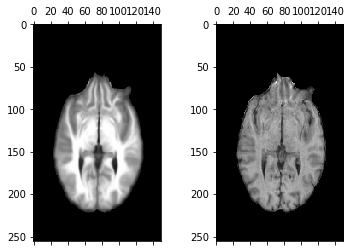

In [26]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(warped_meant1[:, 150, :], cmap='gray')
ax[1].matshow(ants_brain[:, 150, :], cmap='gray')

In [27]:
mapped = np.concatenate([mapping.transform(meanV1[..., 0])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 1])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 2])[..., np.newaxis]], -1) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


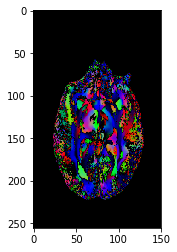

In [28]:
plt.imshow(mapped[:, 150, :])

In [29]:
DWI_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-00.nii.gz')

In [30]:
DWI_affine = DWI_img.affine

In [34]:
resamp = np.concatenate([reg.resample(mapped[..., 0], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 1], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 2], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis]], -1)[:,:,1:-1]
                         

In [35]:
resamp = np.moveaxis(resamp, 2, 0)

In [36]:
resamp.shape

(54, 128, 128, 3)

In [37]:
fake_b.shape

(54, 128, 128, 3)

In [38]:
real_b.shape

(54, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


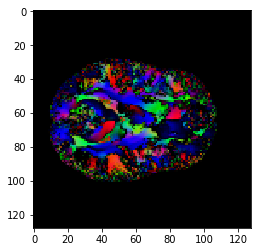

In [39]:
plt.imshow(resamp[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


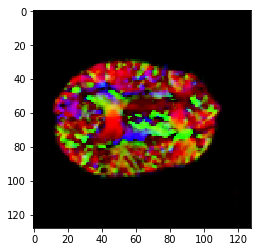

In [40]:
plt.imshow(fake_b[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


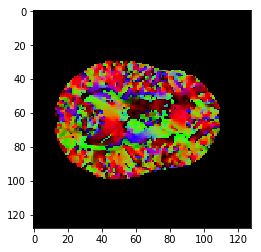

In [41]:
plt.imshow(real_b[27])

In [42]:
mask = (np.abs(real_b).sum(-1)) > 0 

In [62]:
angle_fake = np.rad2deg(np.arccos(np.clip((real_b[mask] * fake_b[mask]).sum(axis=-1), -1, 1)))
angle_fake = np.min(np.array([angle_fake, 180-angle_fake]), 0)

In [63]:
angle_template = np.rad2deg(np.arccos(np.clip((real_b[mask] * resamp[mask]).sum(axis=-1), -1, 1)))
angle_template = np.min(np.array([angle_template, 180-angle_template]), 0)

(array([  768.,  2991.,  4080.,  4506.,  4350.,  4296.,  4351.,  4520.,
         4688.,  5067.,  5861.,  6414.,  7298.,  8849., 10186., 12085.,
        14609., 17490., 20484., 31513.]),
 array([ 1.78077141,  6.19173284, 10.60269427, 15.0136557 , 19.42461713,
        23.83557856, 28.24653999, 32.65750142, 37.06846285, 41.47942428,
        45.89038571, 50.30134714, 54.71230857, 59.12326999, 63.53423142,
        67.94519285, 72.35615428, 76.76711571, 81.17807714, 85.58903857,
        90.        ]),
 <a list of 1 Patch objects>)

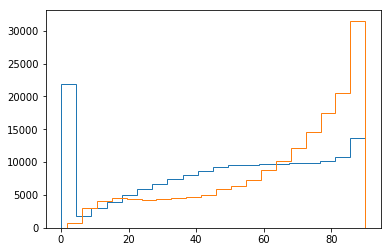

In [64]:
fig, ax = plt.subplots(1)
ax.hist(angle_fake, histtype='step', bins=20)
ax.hist(angle_template, histtype='step', bins=20)